In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc
gc.collect()

1451

In [2]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 5
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_prenatal_signals(shape, o_index):
    matrix = np.zeros(shape)
    mt = matrix.transpose()
    mt[o_index] += 10
    matrix = mt.transpose()
    return matrix

In [5]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [6]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

In [7]:
def plot_lateral_distribution(name):
    if (name == 'L3_L3'):
        shape = (n_L3, n_L3)
        radius = 1; inner = False
    elif (name == 'L3_L2'):
        shape = (n_L3, n_L2)
        radius = 0; inner = True
        
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    list_dic = {}; sum_dic = {}; total_sum = 0
    
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}
    for s_index in range(orientations):
        for t_index in range(orientations):
            list_dic[c[s_index]+c[t_index]] = []
            sum_dic[c[s_index]+c[t_index]] = 0

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), radius, inner, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        list_dic[c[s_index]+c[t_index]].append(weights[source][target])
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        total_sum += abs(weights[source][target])
                        
    plt.figure(figsize=(17,4))
    for s_index in range(orientations):
        for t_index in range(orientations):
            plt.plot(list_dic[c[s_index]+c[t_index]], label=c[s_index]+c[t_index])
            print(c[s_index]+c[t_index], sum_dic[c[s_index]+c[t_index]], 
                  'of', total_sum, ':', sum_dic[c[s_index]+c[t_index]]*100/total_sum)
    
    plt.legend(); plt.show()

In [8]:
def normalize_weights(o_index):
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape((n_L3, n_L3))
    w_ar = np.array([])
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                w_ar = np.append(w_ar, weights[source][target])
    
    q90 = np.percentile(w_ar, 90)
    q10 = np.percentile(w_ar, 10)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                if (weights[source][target] > q90):
                    weights[source][target] = q90
                elif (weights[source][target] < q10):
                    weights[source][target] = q10
    
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

# INITIALIZE

In [9]:
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

c_length = 15
orientations = 4

h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 40
normalize_interval = 20

single_example_time = 0.45 * second
resting_time = 0.25 * second

delay = {}
delay = (0*ms, 5*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.2 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [10]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [11]:
neuron_groups = {}
neuron_groups_list = [
    ('L4', 'e'), ('L3', 'e'), ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v = v_rest_i - 40.*mV 

input_groups = {}
input_groups['input']   = PoissonGroup(n_L4, 0*Hz)

gc.collect()

1597

In [12]:
def my_method():
    print('slkdfjdlf');

In [13]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

# From input to neruon groups (L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', (n_L4, n_L4))
connections['input_L4']= Synapses(input_groups['input'], neuron_groups['L4'], model=model, on_pre=pre_e, on_post=post)
connections['input_L4'].connect(True)
connections['input_L4'].w = weightMatrix[connections['input_L4'].i, connections['input_L4'].j]
# connections['input_L4'].delay = 'maxDelay'
    
neuron_neuron_conn = [
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1474

In [14]:
spike_monitors = {}
spike_monitors['input'] = SpikeMonitor(input_groups['input'])
for name,_ in neuron_groups_list:
    spike_monitors[name] = SpikeMonitor(neuron_groups[name])
    
M = {}
# M['L3_L3'] = StateMonitor(connections['L3_L3'], ['w', 'post', 'pre'], record=True)
# M['L3_L2'] = StateMonitor(connections['L3_L2'], ['w', 'post', 'pre'], record=True)
# M['L3'] = StateMonitor(neuron_groups['L3'], ['v', 'g_e', 'g_i'], record=True)
# M['L2'] = StateMonitor(neuron_groups['L2'], ['v', 'g_e', 'g_i'], record=True)

In [15]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors, M]:
    for key in obj_list:
        net.add(obj_list[key])

hh 994.3785899727826 of 9906.36256080273 : 10.037777073769915
hv 495.17360741951364 of 9906.36256080273 : 4.998541133339954
hd1 495.26144577402414 of 9906.36256080273 : 4.999427819588022
hd2 495.2767910912543 of 9906.36256080273 : 4.999582723238439
vh 495.21498998888245 of 9906.36256080273 : 4.9989588706185435
vv 993.2673267195152 of 9906.36256080273 : 10.026559401829816
vd1 495.22462242653484 of 9906.36256080273 : 4.999056105477386
vd2 495.3398273880564 of 9906.36256080273 : 5.000219044556331
d1h 495.3789233461039 of 9906.36256080273 : 5.0006136995854344
d1v 495.2659026648053 of 9906.36256080273 : 4.9994728097724
d1d1 979.0819485526675 of 9906.36256080273 : 9.883364782414453
d1d2 495.40168817400547 of 9906.36256080273 : 5.000843499653441
d2h 495.279738642938 of 9906.36256080273 : 4.999612477365301
d2v 495.2720986059045 of 9906.36256080273 : 4.999535354839382
d2d1 495.4208921593755 of 9906.36256080273 : 5.001037354716307
d2d2 996.124167876395 of 9906.36256080273 : 10.05539784923516


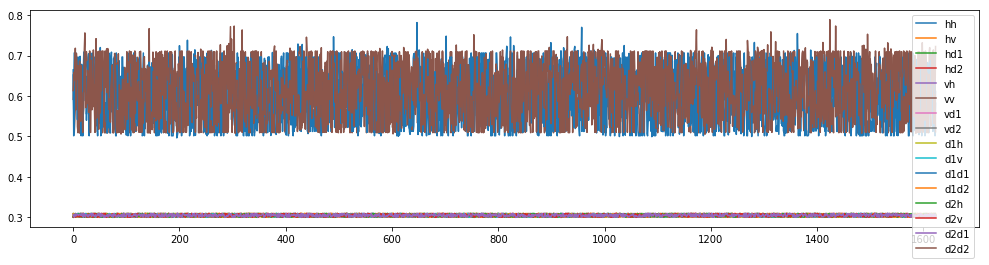

4959

In [16]:
plot_lateral_distribution('L3_L3')
gc.collect()

hh 1801.1608508827057 of 28817.967475433223 : 6.250131458501234
hv 1801.1114580528665 of 28817.967475433223 : 6.249960062548756
hd1 1801.1273108654882 of 28817.967475433223 : 6.250015072717795
hd2 1801.0917772229368 of 28817.967475433223 : 6.249891768940103
vh 1801.1022851519695 of 28817.967475433223 : 6.24992823205653
vv 1801.106132253203 of 28817.967475433223 : 6.249941581718462
vd1 1801.1752063494048 of 28817.967475433223 : 6.25018127279404
vd2 1801.1828057485516 of 28817.967475433223 : 6.250207643144945
d1h 1801.1168502153955 of 28817.967475433223 : 6.249978773662
d1v 1801.0540635169696 of 28817.967475433223 : 6.24976090021732
d1d1 1801.0775725341562 of 28817.967475433223 : 6.249842477855321
d1d2 1801.1699624907742 of 28817.967475433223 : 6.2501630763038305
d2h 1801.0584729699 of 28817.967475433223 : 6.249776201271893
d2v 1801.1599629631917 of 28817.967475433223 : 6.2501283773695935
d2d1 1801.1450831682664 of 28817.967475433223 : 6.250076743627769
d2d2 1801.12768104743 of 28817.967

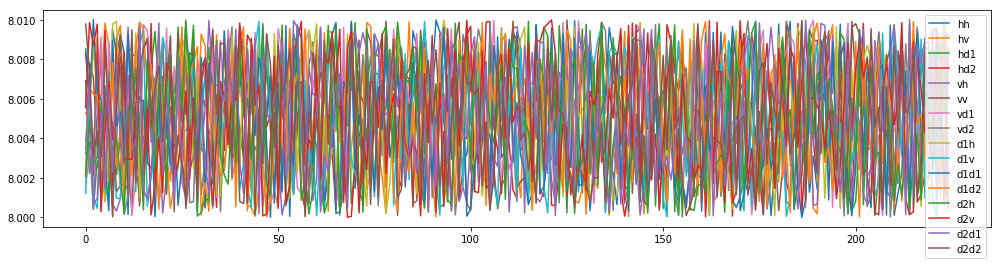

4680

In [17]:
plot_lateral_distribution('L3_L2')
gc.collect()

# TRAIN

In [18]:
previous_spike_count = np.zeros(n_L4)
input_groups['input'].rates = 0 * Hz

selected_orientations = [h_index, v_index, d1_index, d2_index, h_index, v_index, d1_index, d2_index]

for o_index in selected_orientations: 
    net.run(resting_time)
    
    for name, e_i in neuron_groups_list:
        if (e_i == 'e'):
            neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
            
    # load stimuli
    prenatal_stimuli = get_prenatal_signals((c_length,c_length,orientations), o_index)

    j = 0
    while j < (num_epochs):
        if ((j+1) % normalize_interval == 0):
            normalize_weights(o_index)
        
        spike_rates = prenatal_stimuli.reshape((n_L4)) / 8. *  input_intensity
        input_groups['input'].rates = spike_rates * Hz

        print('run example number:', j+1, 'of', num_epochs, 'in iteration', o_index, 'of', len(selected_orientations))
        
        net.run(single_example_time, report='text')   # 0.35 s

        current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
        previous_spike_count = np.copy(spike_monitors['L4'].count[:])
        
        input_groups['input'].rates = 0 * Hz
        net.run(resting_time) 

        if np.sum(current_spike_count) < 1:
            if (input_intensity == 5):
                break;
            print("F - spike count", np.sum(current_spike_count))
            input_intensity += 1
        else:     
            print("S - spike count", np.sum(current_spike_count))
            input_intensity = start_input_intensity
            j += 1

        # garbage collect after each iteration
        gc.collect()

run example number: 1 of 40 in iteration 0 of 8
Starting simulation at t=250. ms for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 97.0
run example number: 2 of 40 in iteration 0 of 8
Starting simulation at t=0.95 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 94
run example number: 3 of 40 in iteration 0 of 8
Starting simulation at t=1.65 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 101
run example number: 4 of 40 in iteration 0 of 8
Starting simulation at t=2.35 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 105
run example number: 5 of 40 in iteration 0 of 8
Starting simulation at t=3.05 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 123
run example number: 6 of 40 in iteration 0 of 8
Starting simulation at t=3.75 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 122
run example number: 7 of 40 in iteration 0 of 8
Starting simulation at t=4.45 s f

S - spike count 100
run example number: 14 of 40 in iteration 1 of 8
Starting simulation at t=37.6 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 108
run example number: 15 of 40 in iteration 1 of 8
Starting simulation at t=38.3 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 104
run example number: 16 of 40 in iteration 1 of 8
Starting simulation at t=39. s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 100
run example number: 17 of 40 in iteration 1 of 8
Starting simulation at t=39.7 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 121
run example number: 18 of 40 in iteration 1 of 8
Starting simulation at t=40.4 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 118
run example number: 19 of 40 in iteration 1 of 8
Starting simulation at t=41.1 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 130
run example number: 20 of 40 in iteration 1 of 8
Starting

Starting simulation at t=74.95 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 103
run example number: 28 of 40 in iteration 2 of 8
Starting simulation at t=75.65 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 106
run example number: 29 of 40 in iteration 2 of 8
Starting simulation at t=76.35 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 120
run example number: 30 of 40 in iteration 2 of 8
Starting simulation at t=77.05 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 109
run example number: 31 of 40 in iteration 2 of 8
Starting simulation at t=77.75 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 115
run example number: 32 of 40 in iteration 2 of 8
Starting simulation at t=78.45 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 104
run example number: 33 of 40 in iteration 2 of 8
Starting simulation at t=79.15 s for a duration of 0.45 s
0.45 (100%) 

0.45 (100%) simulated in 5s
S - spike count 104
run example number: 1 of 40 in iteration 0 of 8
Starting simulation at t=113.25 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 111
run example number: 2 of 40 in iteration 0 of 8
Starting simulation at t=113.95 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 100
run example number: 3 of 40 in iteration 0 of 8
Starting simulation at t=114.65 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 110
run example number: 4 of 40 in iteration 0 of 8
Starting simulation at t=115.35 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 117
run example number: 5 of 40 in iteration 0 of 8
Starting simulation at t=116.05 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 118
run example number: 6 of 40 in iteration 0 of 8
Starting simulation at t=116.75 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 101
run example number: 7 

0.45 (100%) simulated in 3s
S - spike count 106
run example number: 14 of 40 in iteration 1 of 8
Starting simulation at t=150.6 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 107
run example number: 15 of 40 in iteration 1 of 8
Starting simulation at t=151.3 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 110
run example number: 16 of 40 in iteration 1 of 8
Starting simulation at t=152. s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 94
run example number: 17 of 40 in iteration 1 of 8
Starting simulation at t=152.7 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 104
run example number: 18 of 40 in iteration 1 of 8
Starting simulation at t=153.4 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 114
run example number: 19 of 40 in iteration 1 of 8
Starting simulation at t=154.1 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 123
run example number: 20 o

0.45 (100%) simulated in 3s
S - spike count 94
run example number: 27 of 40 in iteration 2 of 8
Starting simulation at t=187.95 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 103
run example number: 28 of 40 in iteration 2 of 8
Starting simulation at t=188.65 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 120
run example number: 29 of 40 in iteration 2 of 8
Starting simulation at t=189.35 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 117
run example number: 30 of 40 in iteration 2 of 8
Starting simulation at t=190.05 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 95
run example number: 31 of 40 in iteration 2 of 8
Starting simulation at t=190.75 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 112
run example number: 32 of 40 in iteration 2 of 8
Starting simulation at t=191.45 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 103
run example number

0.45 (100%) simulated in 3s
S - spike count 112
run example number: 40 of 40 in iteration 3 of 8
Starting simulation at t=225.3 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 100


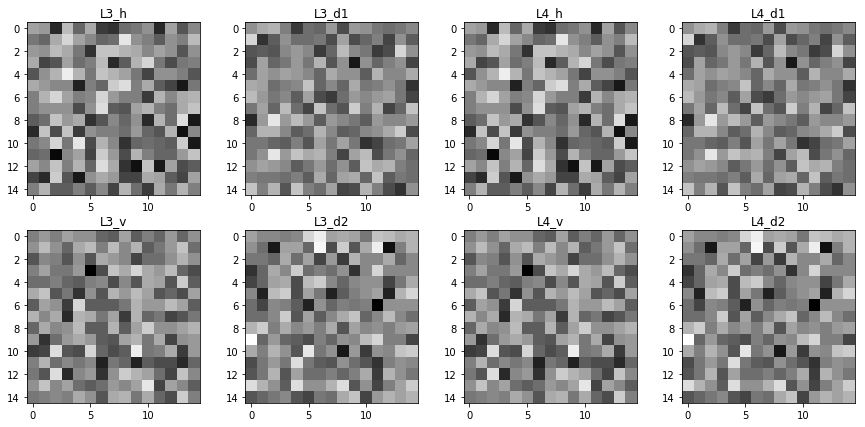

In [19]:
c_shape = (c_length, c_length, orientations)
fig, axarr = subplots(2,4, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h')
axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v')
axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1')
axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2')


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')

In [20]:
gc.collect()

30

hh 1244.984665717394 of 10921.478511790372 : 11.399415055144416
hv 495.17362748613067 of 10921.478511790372 : 4.533943155696016
hd1 495.26144577402414 of 10921.478511790372 : 4.534747243602233
hd2 495.2767907107049 of 10921.478511790372 : 4.534887745977111
vh 495.21498974125893 of 10921.478511790372 : 4.5343218796488545
vv 1245.171733276055 of 10921.478511790372 : 11.401127896116076
vd1 495.2246690318436 of 10921.478511790372 : 4.534410505841492
vd2 495.3398273880564 of 10921.478511790372 : 4.535464926779906
d1h 495.3789233461039 of 10921.478511790372 : 4.535822899906028
d1v 495.26590197792217 of 10921.478511790372 : 4.534788045805829
d1d1 1239.2168600455398 of 10921.478511790372 : 11.346603472302153
d1d2 495.4017292064995 of 10921.478511790372 : 4.536031716508754
d2h 495.2797649666257 of 10921.478511790372 : 4.5349149790657215
d2v 495.2720986059045 of 10921.478511790372 : 4.53484478380129
d2d1 495.4208915918523 of 10921.478511790372 : 4.536207172472267
d2d2 1248.59459292456 of 10921.4

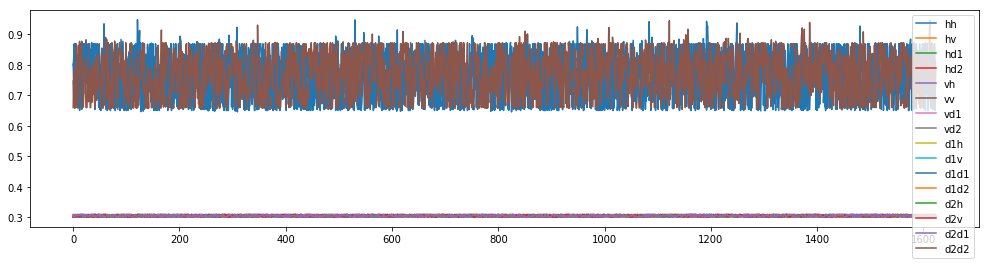

In [21]:
plot_lateral_distribution('L3_L3')

hh 1801.1608508827057 of 28817.967475433223 : 6.250131458501234
hv 1801.1114580528665 of 28817.967475433223 : 6.249960062548756
hd1 1801.1273108654882 of 28817.967475433223 : 6.250015072717795
hd2 1801.0917772229368 of 28817.967475433223 : 6.249891768940103
vh 1801.1022851519695 of 28817.967475433223 : 6.24992823205653
vv 1801.106132253203 of 28817.967475433223 : 6.249941581718462
vd1 1801.1752063494048 of 28817.967475433223 : 6.25018127279404
vd2 1801.1828057485516 of 28817.967475433223 : 6.250207643144945
d1h 1801.1168502153955 of 28817.967475433223 : 6.249978773662
d1v 1801.0540635169696 of 28817.967475433223 : 6.24976090021732
d1d1 1801.0775725341562 of 28817.967475433223 : 6.249842477855321
d1d2 1801.1699624907742 of 28817.967475433223 : 6.2501630763038305
d2h 1801.0584729699 of 28817.967475433223 : 6.249776201271893
d2v 1801.1599629631917 of 28817.967475433223 : 6.2501283773695935
d2d1 1801.1450831682664 of 28817.967475433223 : 6.250076743627769
d2d2 1801.12768104743 of 28817.967

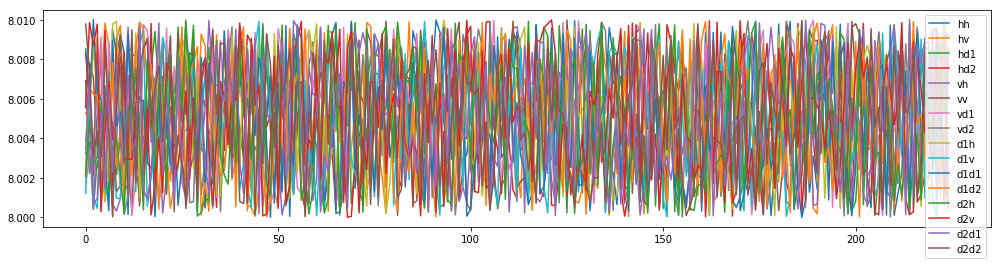

In [22]:
plot_lateral_distribution('L3_L2')

In [23]:
# save connections
save_connections()

input_L4 L4_L3 L3_L3 L3_L2 L2_L3 L3_L4 connections saved


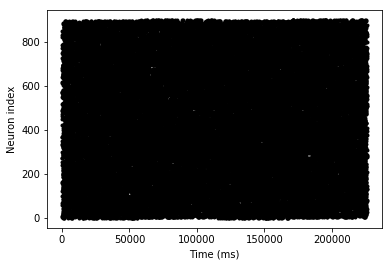

In [24]:
plot(spike_monitors['input'].t/ms, spike_monitors['input'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

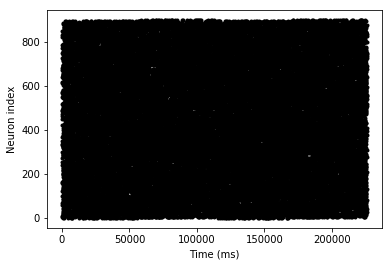

In [25]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

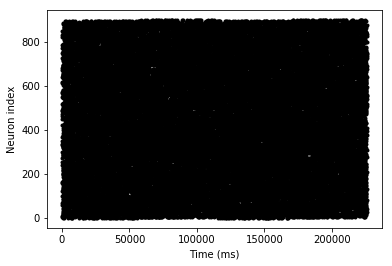

In [26]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

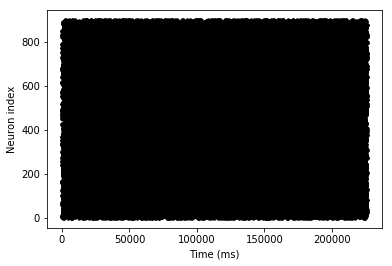

In [27]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [28]:
gc.collect()

18029

In [29]:
# figure(figsize=(15, 4))
# plot(M['L2'].t/ms, M['L2'].v[8], label='L2')
# plot(M['L3'].t/ms, M['L3'].v[8], label='L3')
# legend()

In [30]:
unique(connections['L3_L3'].w)

array([-9.99354711e-08, -9.57491398e-08, -8.01765945e-08, ...,
        1.10516219e+01,  1.12151776e+01,  1.12905075e+01])

In [31]:
unique(connections['L3_L2'].w)

array([0.        , 8.00000053, 8.00000461, ..., 8.00999185, 8.00999468,
       8.0099966 ])

In [ ]:
weights = np.array(connections['L3_L3'].w)

In [ ]:
weights[0]

In [ ]:
weights.shape

In [ ]:
plot(weights)

In [ ]:
 weights = weights.reshape((n_L3, n_L3))

In [ ]:
weights = weights.reshape(n_L3*n_L3)

In [ ]:
plot(weights)

In [ ]:
weights[0]

In [ ]:
0.24000009828939875